PROCESSING RESPONSES FROM HGRU MODEL

In [1]:
from utils_req import *

In [2]:
Model = 'BSDS500'
# Model = 'Pathfinder'

In [3]:
# 1. Load the Monet stimulus movies
Data = loadmat('./Monet/MonetMovies.mat')
MonetMovies = Data['MonetMovies']
del Data

Ny, Nx, T = MonetMovies.shape[0:3]
N_Contrastlevels = 10 #no. of contrast levels 
NClips = 100 # no. of clips, each presented at different contrast levels
MonetMovies = MonetMovies.reshape(Ny,Nx,T,N_Contrastlevels,NClips)
MonetMovies = MonetMovies.transpose(3,4,2,0,1)

# These are the movies required to compute the STA
MonetMoviesReq = MonetMovies[-1,0:10,0:296].reshape(10,37,8,36,64)
del MonetMovies

# 2. Load the responses to highest contrast bin
fname = './hGRU_Analysis/' + Model + '/MonetResponses/monet_hgru_900.npy'
responses = np.load(fname)
responses = responses.reshape(10,37,8,-1)
NNeu = responses.shape[3]

In [4]:
"""
Compute receptive fields using STA of responses to Monet
1. Load the Monet stimulus movies
2. Load the responses corresponding to the highest contrast bin
3. Compute STA for all neurons if 
"""
# 1. Load the Monet stimulus movies
Data = loadmat('./Monet/MonetMovies.mat')
MonetMovies = Data['MonetMovies']
del Data

Ny, Nx, T = MonetMovies.shape[0:3]
N_Contrastlevels = 10 #no. of contrast levels 
NClips = 100 # no. of clips, each presented at different contrast levels
MonetMovies = MonetMovies.reshape(Ny,Nx,T,N_Contrastlevels,NClips)
MonetMovies = MonetMovies.transpose(3,4,2,0,1)

# These are the movies required to compute the STA
MonetMoviesReq = MonetMovies[-1,0:10,0:296].reshape(10,37,8,36,64)
del MonetMovies

# 2. Load the responses to highest contrast bin
fname = './hGRU_Analysis/' + Model + '/MonetResponses/monet_hgru_900.npy'
responses = np.load(fname)
responses = responses.reshape(10,37,8,-1)
NNeu = responses.shape[3]

# 3. Compute STA if it has not been computed yet
fname = './hGRU_Analysis/' + Model + '/ReceptiveFields.mat'
if Path(fname).exists():
    Data = loadmat(fname)
    ReceptiveFields = Data['ReceptiveFields']
    del Data
else:
    MonetMoviesReq = MonetMoviesReq - 127.5
    ReceptiveFields = np.zeros([NNeu,Ny,Nx])
    lag = 1
    # obtain the RFs using STA
    for nn in tqdm(range(NNeu)):
        ReceptiveFields[nn,:,:] = np.sum((MonetMoviesReq[:,:,:8-lag]*expandN_dims(responses[:,:,lag:,nn],2)).reshape(-1,Ny,Nx),axis=0)/(10*37*(8-lag))
        
    mdict = {'ReceptiveFields':ReceptiveFields}
    savemat(fname,mdict)

In [5]:
# Compute the RF centers and quality of RFs
ReceptiveFields, RxVec, RyVec, RF_snr = ProcessReceptiveFields(ReceptiveFields)

In [6]:
"""
Estimate the local orientations and contrasts for Monet if they have not been computed already
"""

fname = './Monet/EstimatedContrast_Monet.mat'
if Path(fname).exists():
    Data = loadmat(fname)
    ChatFull = Data['ChatFull']
    fname = './Monet/EstimatedOrientation_Monet.mat'
    Data = loadmat(fname)
    OhatFull = Data['OhatFull']
    del Data
    
else:
    OhatFull = np.zeros(MonetMovies.shape)
    ChatFull = np.zeros(MonetMovies.shape)

    # paramters for estimating orientation and contrast
    ksize = 19
    sigma_o = 5
    sigma_c = 5
    rs = 1.0

    for clip in tqdm(range(NClips)):
        for nbin in range(N_Contrastlevels):
            for t in range(T):
                OhatFull[nbin,clip,t], ChatFull[nbin,clip,t] = Extract_Orientation_Contrast(np.double(MonetMovies[nbin,clip,t]),ksize, sigma_o, sigma_c, rs)
                
    # Quantize Chat and Ohat
    OhatFull = np.uint8(np.floor(256*OhatFull/np.pi))
    ChatFull = np.uint8(np.floor(256*ChatFull/np.max(ChatFull[-1])))

    # save the files
    mdict = {'OhatFull':OhatFull}
    fname = './Monet/EstimatedOrientation_Monet.mat'
    savemat(fname, mdict)

    mdict = {'ChatFull':ChatFull}
    fname = './Monet/EstimatedContrast_Monet.mat'
    savemat(fname, mdict)   
    
    
OhatFull = OhatFull[:,0:10,0:296].reshape(10,10,37,8,36,64)
ChatFull = ChatFull[:,0:10,0:296].reshape(10,10,37,8,36,64)

In [7]:
"""
Build 2D tuning curves, if not computed yet
"""

Nbins_o = 11 #no. of orientation bins
Nbins_c = 21 #no. of contrast bins

fname = './hGRU_Analysis/' + Model + '/TuningData.mat'
if Path(fname).exists():
    Data = loadmat(fname)
    TuningCurves_2D = Data['TuningCurves_2D']
    BinCounts = Data['BinCounts']
    del Data

else:
    
    # now to build 2D tuning curves using the Monet stimulus

    TuningCurves_2D = np.zeros([NNeu, Nbins_c, Nbins_o]) # No. of Monet stimulus clips x No. of neurons x No. of orientation bins

    BinCounts = np.zeros([NNeu, Nbins_c, Nbins_o])

    t_st = time.time()

    for clevel in range(N_Contrastlevels):
        # load the responses for Monet at this contrast level
        fname = './hGRU_Analysis/' + Model + '/MonetResponses/monet_hgru_' + str(clevel) + '00.npy'
        print(fname)
        responses = np.load(fname)
        responses = responses.reshape(10,37,8,-1)

        # quantize the required orientation and contrast maps
        ChatReq = np.uint8(np.floor(ChatFull[clevel]*(Nbins_c/256.0))) 
        OhatReq = np.uint8(np.floor(OhatFull[clevel]*(Nbins_o/256.0))) 

        for nn in tqdm(range(NNeu)):

            R_nn = responses[:,:,:,nn].flatten() #responses of neuron nn

            # receptive field centers of neuron nn
            px = RxVec[nn]
            py = RyVec[nn]

            for ii in range(Nbins_c):

                idx_c = np.nonzero(ChatReq[:,:,:,py,px].flatten() == ii)[0] #find indices where contrast = ii

                for jj in range(Nbins_o):

                    idx_o = np.nonzero(OhatReq[:,:,:,py,px].flatten() == jj)[0] #find indices where orientation = jj
                    idx_oc = np.intersect1d(idx_c, idx_o)  # intersection of contrast and orientation bin

                    BinCounts[nn,ii,jj] = BinCounts[nn,ii,jj] + len(idx_oc)

                    TuningCurves_2D[nn,ii,jj] = TuningCurves_2D[nn,ii,jj] + np.sum(R_nn[idx_oc])
                    
      # save raw Tuning Curve data
    mdict = {'TuningCurves_2D':TuningCurves_2D, 'BinCounts': BinCounts}
    fname = './hGRU_Analysis/' + Model + '/TuningData.mat'
    savemat(fname, mdict)  


Total no. of neurons = 55296
No. of neurons selected for constructing PPCs = 12939


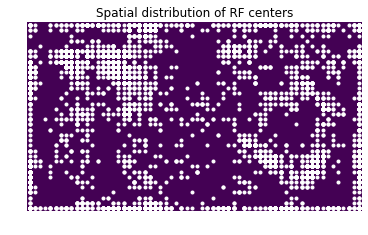

In [8]:
"""
Select the neurons with RF_snr > Th and plot the spatial distribution of the RF centers
"""

print('Total no. of neurons =', NNeu)

SNR_Threshold = 3.8
NIdx = np.nonzero(RF_snr > SNR_Threshold)[0]

# Retain information of only these neurons
ReceptiveFields = ReceptiveFields[NIdx]
RxVec = RxVec[NIdx]
RyVec = RyVec[NIdx]
RF_snr = RF_snr[NIdx]
NNeu = len(RF_snr)
TuningCurves_2D = TuningCurves_2D[NIdx]
BinCounts = BinCounts[NIdx]

print('No. of neurons selected for constructing PPCs =', NNeu)

plt.imshow(np.zeros([Ny,Nx]))
plt.plot(RxVec,RyVec,'w.')
plt.axis('off')
plt.title('Spatial distribution of RF centers')
plt.show()

Plotting RFs of neurons with best RF_snr


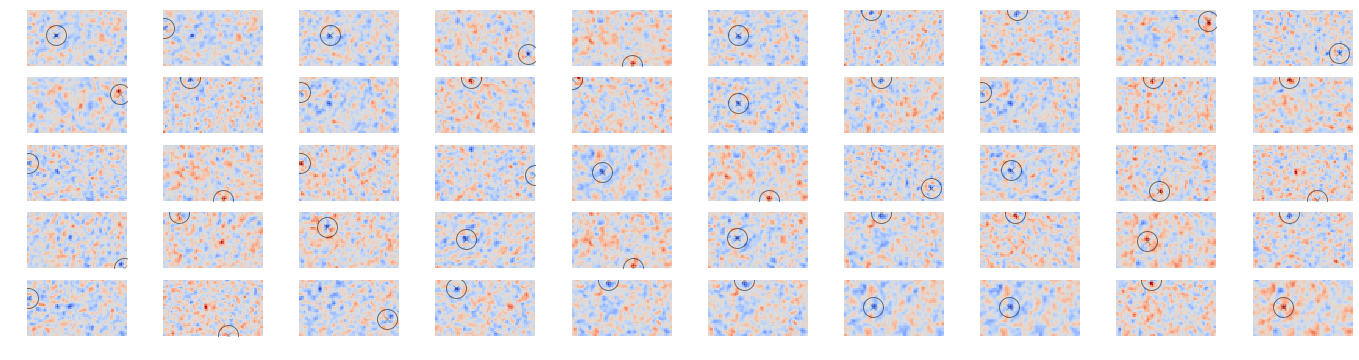

In [9]:
print('Plotting RFs of neurons with best RF_snr')
sortidx = np.argsort(-RF_snr)
plt.subplots(5,10,figsize=(24,6))
for k in range(50):
    plt.subplot(5,10,k+1)
    #nidx = np.random.randint(NNeu)
    nidx = sortidx[k]
    plt.imshow(ReceptiveFields[nidx,:,:],cmap = 'coolwarm',vmin = -1,vmax=1)    
    plt.plot(RxVec[nidx],RyVec[nidx],'o',markersize=20,mec='k',mfc="None",alpha = 0.5)
    plt.plot(RxVec[nidx],RyVec[nidx],'kx',alpha=0.25)
    plt.axis('off')
plt.show()

Plotting RFs of randomly selected neurons


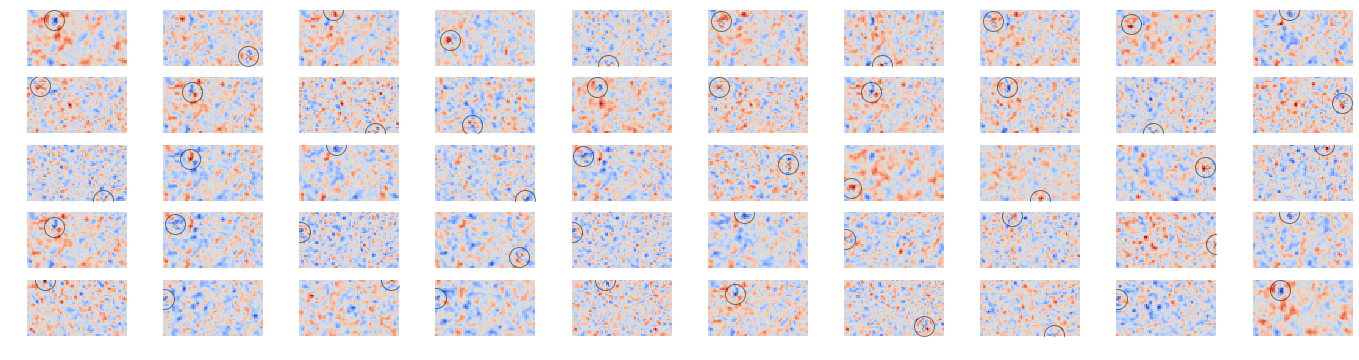

In [11]:
print('Plotting RFs of randomly selected neurons')
plt.subplots(5,10,figsize=(24,6))
for k in range(50):
    plt.subplot(5,10,k+1)
    nidx = np.random.randint(NNeu)
    plt.imshow(ReceptiveFields[nidx,:,:],cmap = 'coolwarm',vmin = -1,vmax=1)    
    plt.plot(RxVec[nidx],RyVec[nidx],'o',markersize=20,mec='k',mfc="None",alpha = 0.5)
    plt.plot(RxVec[nidx],RyVec[nidx],'kx',alpha=0.25)
    plt.axis('off')
plt.show()

In [12]:
# Pick only contrast bins 4 through 11
TuningCurves_2D = TuningCurves_2D[:,4:12,:]/BinCounts[:,4:12,:]

# orientation and contrast bin values for fitting
ori_set = (2*np.arange(Nbins_o)+1)*np.pi/2/Nbins_o
cont_set = (2*np.arange(Nbins_c)+1)/Nbins_c/2
cont_set = cont_set[4:12]
ori_2D,cont_2D = np.meshgrid(ori_set,cont_set)
tuningFn_inputs = np.concatenate((np.expand_dims(cont_2D.flatten(),axis=0),np.expand_dims(ori_2D.flatten(),axis=0)),axis=0)

Nbins_c = len(cont_set)
Nbins_o = len(ori_set)

In [13]:
"""
Compute fits to tuning curves
We assume tuning curves are of the form c_A*tanh(c_B*contrast + c_C)*exp(k1*cos(2(theta-mu1)) + k2*cos(4(theta-mu2)))
"""

fname = './hGRU_Analysis/' + Model + '/TuningFitInfo.mat'

if Path(fname).exists():
    Data = loadmat(fname)
    c_A = Data['c_A'].squeeze()
    c_B = Data['c_B'].squeeze()
    c_C = Data['c_C'].squeeze()
    k1 = Data['k1'].squeeze()
    k2 = Data['k2'].squeeze()
    mu1 = Data['mu1'].squeeze()
    mu2 = Data['mu2'].squeeze()
    TuningCurves_Max = Data['TuningCurves_Max'].squeeze()
    TuningCurves_Fit = Data['TuningCurves_Fit']
    FitError = Data['FitError'].squeeze()
    
else:

    # Parameters of the tuning function
    c_A = np.zeros([NNeu]) # contrast tuning amplitude
    c_B = np.zeros([NNeu]) # contrast tuning slope
    c_C = np.zeros([NNeu]) # contrast tuning offset
    k1  = np.zeros([NNeu]) # orientation tuning concentration parameter 1st order
    mu1 = np.zeros([NNeu]) # preferred orientation 1st order
    k2  = np.zeros([NNeu]) # orientation tuning concentration parameter 2nd order
    mu2 = np.zeros([NNeu]) # preferred orientation 2nd order

    # initial values and bounds for the parameters
    init_vals = [1, 1, 0, 1, np.pi/2, 0, 0]
    lb = [-3,-3,-3,0,0,0,0]
    ub = [3,3,3,5,np.pi,5,np.pi/2]


    FitError = np.zeros([NNeu])
    TuningCurves_Fit = np.zeros(TuningCurves_2D.shape)

    TuningCurves_Max = np.zeros([NNeu])

    for k in tqdm(range(NNeu)):
        TuningCurves_Max[k] = np.max(np.abs(TuningCurves_2D[k]))
        best_vals, covar = curve_fit(TuningFunction, tuningFn_inputs, TuningCurves_2D[k].reshape(-1)/TuningCurves_Max[k], p0=init_vals,bounds=(lb,ub),max_nfev=30000)
        c_A[k] = best_vals[0]
        c_B[k] = best_vals[1]
        c_C[k] = best_vals[2]
        k1[k]  = best_vals[3]
        mu1[k] = best_vals[4]
        k2[k]  = best_vals[5]
        mu2[k] = best_vals[6]

        Fit = TuningFunction(tuningFn_inputs,c_A[k],c_B[k],c_C[k],k1[k],mu1[k],k2[k],mu2[k])
        FitError[k] = MSE(Fit,TuningCurves_2D[k]/TuningCurves_Max[k])
        TuningCurves_Fit[k] = Fit.reshape(len(cont_set),len(ori_set))

    mdict = {'c_A': c_A, 'c_B': c_B, 'c_C': c_C, 'k1': k1, 'mu1': mu1, 'k2': k2, 'mu2': mu2, 'TuningCurves_Max':TuningCurves_Max, 'TuningCurves_Fit': TuningCurves_Fit, 'FitError': FitError}
    fname = './hGRU_Analysis/' + Model + '/TuningFitInfo.mat'
    savemat(fname, mdict)  

100%|██████████| 12939/12939 [16:41<00:00, 12.91it/s]


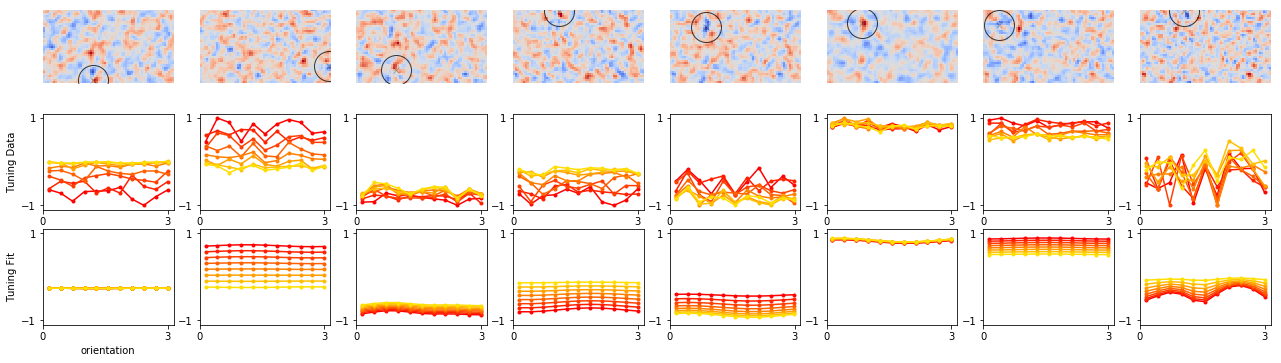

In [15]:
"""
Plot RF, tuning data and fit to tuning data for some example neurons
"""

Nplots = 8
fig, ax = plt.subplots(3,Nplots,figsize=(22,6))
for k in range(Nplots):
    nidx = np.random.randint(NNeu)
    ax[0,k].imshow(ReceptiveFields[nidx,:,:],cmap = 'coolwarm',vmin = -1,vmax=1)    
    ax[0,k].plot(RxVec[nidx],RyVec[nidx],'o',markersize=30,mec='k',mfc="None",alpha = 0.75)
    ax[0,k].plot(RxVec[nidx],RyVec[nidx],'kx',alpha=0.25)
    ax[0,k].axis('off')
    
    for n in range(Nbins_c):
        ax[1,k].plot(ori_set,TuningCurves_2D[nidx,n]/TuningCurves_Max[nidx],color=tuple([1,n*0.125,0]),marker ='.')
        ax[2,k].plot(ori_set,TuningCurves_Fit[nidx,n],color=tuple([1,n*0.125,0]),marker ='.')
    ax[1,k].set_xticks([0,3])
    ax[2,k].set_xticks([0,3])
    ax[1,k].set_yticks([-1,1])
    ax[2,k].set_yticks([-1,1])
    ax[1,k].axis([0,np.pi,-1.1,1.1])
    ax[2,k].axis([0,np.pi,-1.1,1.1])

ax[1,0].set_ylabel('Tuning Data')
ax[2,0].set_ylabel('Tuning Fit')
ax[2,0].set_xlabel('orientation')
plt.show()



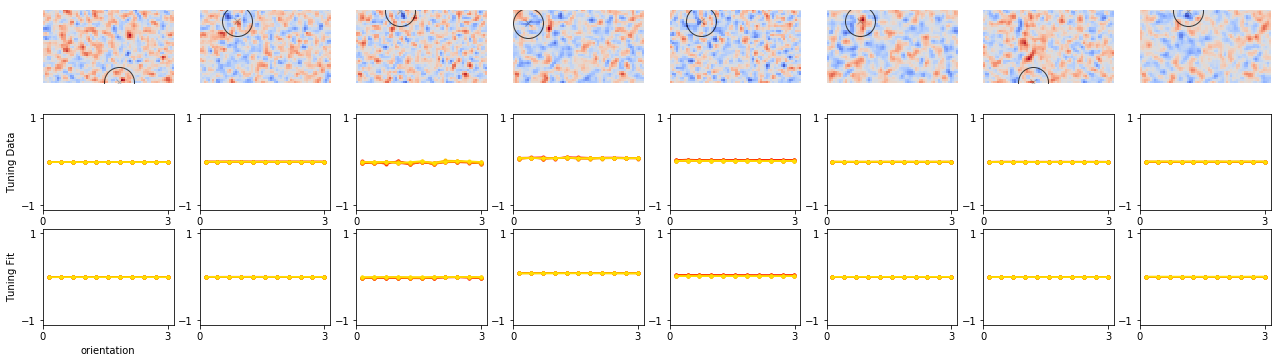

In [16]:
"""
Plot RF, tuning data and fit to tuning data for some example neurons
"""

Nplots = 8
fig, ax = plt.subplots(3,Nplots,figsize=(22,6))
for k in range(Nplots):
    nidx = np.random.randint(NNeu)
    ax[0,k].imshow(ReceptiveFields[nidx,:,:],cmap = 'coolwarm',vmin = -1,vmax=1)    
    ax[0,k].plot(RxVec[nidx],RyVec[nidx],'o',markersize=30,mec='k',mfc="None",alpha = 0.75)
    ax[0,k].plot(RxVec[nidx],RyVec[nidx],'kx',alpha=0.25)
    ax[0,k].axis('off')
    
    for n in range(Nbins_c):
        ax[1,k].plot(ori_set,TuningCurves_2D[nidx,n],color=tuple([1,n*0.125,0]),marker ='.')
        ax[2,k].plot(ori_set,TuningCurves_Fit[nidx,n]*TuningCurves_Max[nidx],color=tuple([1,n*0.125,0]),marker ='.')
    ax[1,k].set_xticks([0,3])
    ax[2,k].set_xticks([0,3])
    ax[1,k].set_yticks([-1,1])
    ax[2,k].set_yticks([-1,1])
    ax[1,k].axis([0,np.pi,-1.1,1.1])
    ax[2,k].axis([0,np.pi,-1.1,1.1])

ax[1,0].set_ylabel('Tuning Data')
ax[2,0].set_ylabel('Tuning Fit')
ax[2,0].set_xlabel('orientation')
plt.show()



In [17]:
responses.shape

(10, 37, 8, 55296)

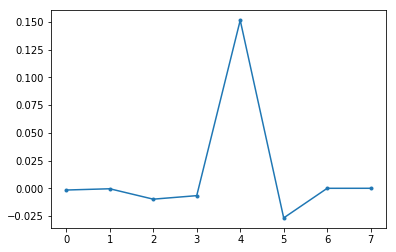

In [21]:
plt.plot(responses[0,0,:,200],'.-')

In [22]:
responses.shape

(10, 37, 8, 55296)

In [23]:
NNeu

12939

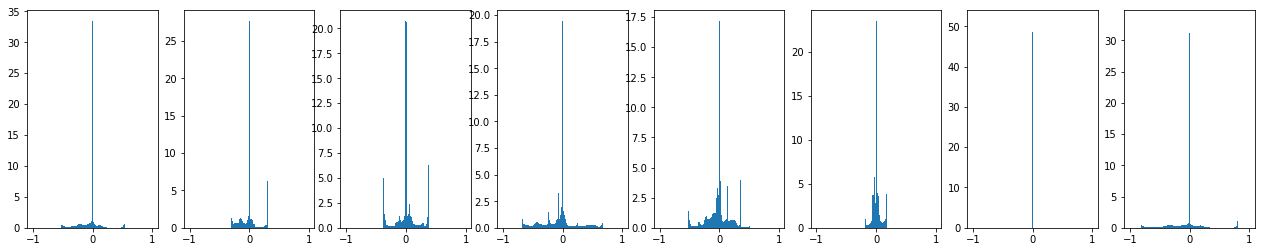

In [38]:
fig, ax = plt.subplots(1,8,figsize=(22,4))
for k in range(8):
    ax[k].hist(responses[:,:,k,:].flatten(),bins = np.arange(-1,1,0.01),density=1)
plt.show()

In [1]:
fig, ax = plt.subplots(1,8,figsize=(22,4))
for k in range(8):
    ax[k].plot(np.sort(responses[:,:,k,:].flatten()),np.arange(len(responses[:,:,k,:].flatten())))
plt.show()